In [122]:
from scipy import stats
from scipy.io import loadmat
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import matplotlib.cm as cm
from Funciones_auxiliares import Mat_to_dataframe,see_teams,get_cluster_indexs,plot_branch,plot_teams,find_mix
from scipy import cluster
from scipy.spatial.distance import mahalanobis
from mpl_toolkits.mplot3d import Axes3D
import copy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import scipy as sp
import math

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [123]:
plt.close('all')
plt.clf()
plt.close()

data = pd.read_pickle('/home/lorenzo/Principal/Noise-Neuron discriminator/Datos/PCCIBbMZASDPCInbW')
data['Mean'] = data.Bulk.apply(lambda row: np.mean(row,axis = 0))
data['Mean'] = (data['Mean'] - data.Mean.apply(lambda row:np.mean(row)))/data.Mean.apply(lambda row:np.std(row))
Number_seesions = len(data.PatientExperiment.unique())
print('There are',Number_seesions,' sessions in the data')

There are 60  sessions in the data


In [124]:
def Train_test_noise(data):
    Sessions_list = data.PatientExperiment.unique()
    Train_list = np.random.choice(Sessions_list, size=int(len(Sessions_list)/2),replace = False)
    Train = data[data.PatientExperiment.isin(Train_list)]
    Test = data[~data.PatientExperiment.isin(Train_list)]
    Train = Train.reset_index().rename(columns = {'index':'old_index'})
    Test = Test.reset_index().rename(columns = {'index':'old_index'})
    
    df_train = Train.copy()
    df_test = Test.copy()
    
    Noise = df_train[df_train.bNoise == 1]
    Neuron = df_train[df_train.bNoise == 0]
    MU = df_train[df_train.bNoise == 2]

    df_train = pd.concat([Neuron,MU,Noise], ignore_index= True, sort = False)

    Noise = df_test[df_test.bNoise == 1]
    Neuron = df_test[df_test.bNoise == 0]
    MU = df_test[df_test.bNoise == 2]

    df_test = pd.concat([Neuron,MU,Noise], ignore_index= True, sort = False)

    Cov = np.array(df_train.Mean.to_list()).T
    Cov = np.cov(Cov)
    
    return df_train,df_test,Cov

df_train,df_test,Cov = Train_test_noise(data)
print(len(df_train),len(df_test))
print(len(df_train.PatientExperiment.unique()),len(df_test.PatientExperiment.unique()))

495 1075
30 30


In [125]:
from scipy.spatial.distance import squareform, pdist

def compute_dist(df_test,df_train,Covariance = False):
    df = pd.concat([df_train,df_test],ignore_index=True,sort = True)
    r = len(df_train)
    if isinstance(Cov,np.ndarray):
        print("Using Mahalanobis distance")
        Dist = pd.DataFrame(squareform(pdist(np.array(df.loc[:, 'Mean'].to_list()),metric = 'mahalanobis',VI = Cov)),columns=df.index,index=df.index).values
    else:
        print("Using Eucliadean Distance")
        Dist = pd.DataFrame(squareform(pdist(np.array(df.loc[:, 'Mean'].to_list()),metric = 'euclidean')),columns=df.index,index=df.index).values
    Dist = Dist[r:,:r]
    return Dist

Dist = compute_dist(df_test,df_train,Cov)

Using Mahalanobis distance


([<matplotlib.axis.XTick at 0x7ff7b2907e90>,
 [Text(0.0, 0, 'neuron_train'),
  Text(0.2, 0, 'mu_train'),
  Text(0.4, 0, 'noise_train')])

([<matplotlib.axis.YTick at 0x7ff7b381d790>,
 [Text(0, 0.0, 'neuron_test'),
  Text(0, 0.2, 'mu_test'),
  Text(0, 0.4, 'noise_test')])

Text(0.5, 1.0, 'Mahalanobis distance')

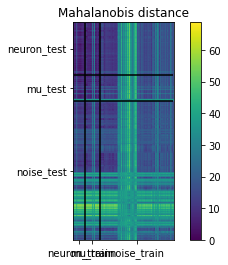

In [126]:
fig,ax = plt.subplots()
fig.canvas.draw()

t2 = df_test[df_test.bNoise == 1].index[0]
m2 = df_test[df_test.bNoise == 2].index[0]
t = df_train[df_train.bNoise == 1].index[0]
m = df_train[df_train.bNoise == 2].index[0]

xlabels = ['neuron_train','mu_train','noise_train']
ylabels = ['neuron_test','mu_test','noise_test']

plt.xticks([m/2,(t+m)/2,(len(Dist[0])+t)/2],xlabels)
plt.yticks([m2/2,(t2+m2)/2,(len(Dist)+t2)/2],ylabels)

plt.title('Mahalanobis distance')

plt.hlines(t2,0,len(Dist[0])-1)
plt.hlines(m2,0,len(Dist[0])-1)

plt.vlines(t,0,len(Dist)-1)
plt.vlines(m,0,len(Dist)-1)

plt.imshow(Dist)
plt.colorbar()


In [127]:
def compute_minn(Dist,number_votes = 4):
    Minn = [np.argsort(i)[:number_votes] for i in Dist[:]]
    Minn = np.array(Minn)
    return Minn
Minn = compute_minn(Dist,4)

In [184]:
def create_label(lista,t,m):
    label = [count_votes(i,t,m) for i in lista]
    return np.array(label)

def count_votes(votes_list,t,m):
    neuron_votes = np.sum(votes_list <= m)
    mu_votes = np.sum((votes_list> m) & (votes_list < t))
    noise_votes = np.sum(votes_list > t)
    winner = np.argmax([neuron_votes + mu_votes,noise_votes])
    if winner != 1:
        decisive = votes_list[np.where(votes_list < t)[0][0]]
        if decisive <= m:winner = 0
        else: winner = 2
    return winner


m,t
Minn
label = create_label(Minn,t,m)
label


(199, 302)

array([[189,  93, 739,  83],
       [668, 116, 307, 426],
       [739, 189,  83, 273],
       ...,
       [500, 481, 561, 487],
       [813, 833, 363, 750],
       [832, 650, 680, 754]])

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 2, 0, 2, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 1, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 0,
       1, 2, 1, 2, 2, 0, 1, 0, 0, 1, 0, 2, 2, 2, 0, 0, 1, 2, 2, 2, 2, 2,
       0, 2, 2, 0, 1, 0, 1, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 0, 0,
       2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 1, 2, 0, 2, 0, 2, 0, 1,
       0, 1, 1, 2, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,

In [185]:
neurons = label[:m2]
mu = label[m2:t2]
m,t
noises = label[t2:]

total_neurons = len(neurons)
total_mu = len(mu)
total_noises = len(noises)

neurons_as_noise = len(np.where(neurons ==1)[0])
neurons_as_mu = len(np.where(neurons ==2)[0])
hits_neuron = len(np.where(neurons ==0)[0])

mu_as_noise = len(np.where(mu == 1)[0])
mu_as_neurons = len(np.where(mu == 0)[0])
hits_mu = len(np.where(mu == 2)[0])

noises_found = sum(noises)

mu_as_noise_index = np.where(mu == 1)[0]
mu_as_noise_index = mu_as_noise_index + m2
noise_matched_index = np.array([Minn[m2+i] for i in mu_as_noise_index]) #notice m2

#noise_matched_index
#df_train.iloc[noise_matched_index]

print('neurons as noise = ',neurons_as_noise/len(neurons)*100,'({})'.format(neurons_as_noise))
print('neurons as mu = ',neurons_as_mu/len(neurons)*100,'({})'.format(neurons_as_mu))
print('neurons hits = ',hits_neuron/len(neurons)*100,'({})'.format(hits_neuron))

print('\n')

print('mu as noise = ',mu_as_noise/len(mu)*100,'({})'.format(mu_as_noise))
print('mu as neuron = ',mu_as_neurons/len(mu)*100,'({})'.format(mu_as_neurons))
print('mu hits = ',hits_mu/len(mu)*100,'({})'.format(hits_mu))

print('\n')
print('Noise found = ', noises_found/len(noises)*100, '({})'.format(noises_found))

(199, 302)

neurons as noise =  7.6923076923076925 (9)
neurons as mu =  13.675213675213676 (16)
neurons hits =  78.63247863247864 (92)


mu as noise =  24.752475247524753 (25)
mu as neuron =  31.683168316831683 (32)
mu hits =  43.56435643564357 (44)


Noise found =  96.90522243713733 (501)


In [130]:
df_train.columns

Index(['old_index', 'PatientExperiment', 'Channel', 'Cluster', 'ISI', 'Bulk',
       'bNoise', 'Mean', 'ZeroCrossings', 'Amplitude', 'Amplitude_peaktopeak',
       'MeanSTD', 'derivative_peak', 'derivative_max', 'power_processing',
       'Counts', 'ISI_noisy_band', 'Width'],
      dtype='object')

In [131]:
features = ["ZeroCrossings","Amplitude_peaktopeak","ISI_noisy_band","power_processing","derivative_max","MeanSTD","Width"]
X_train = df_train[features].values
X_test = df_test[features].values
y_test = df_test.bNoise.values.astype(int)
y_train = df_train.bNoise.values.astype(int)

In [132]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

StandardScaler()

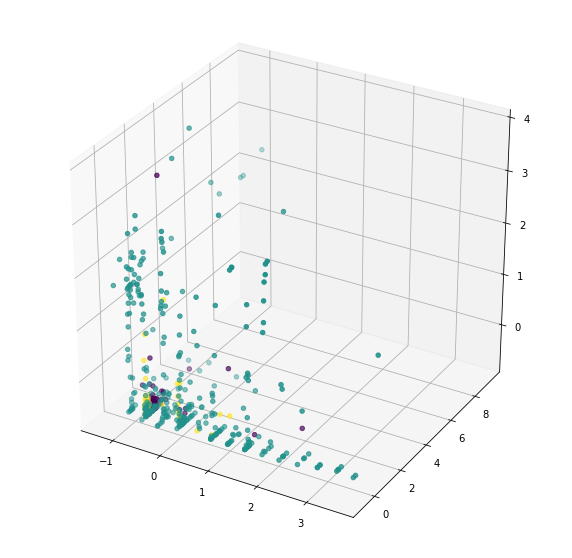

In [133]:
fig= plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection = "3d")
ax.scatter(X_train.T[0],X_train.T[1],X_train.T[2],c = y_train)

In [134]:
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [135]:
y_pred = classifier.predict(X_test)
conf_m = confusion_matrix(y_test, y_pred)

In [136]:
conf_m

array([[123,  70,  66],
       [ 24, 617,  44],
       [ 13,  51,  67]])

In [137]:
len(y_pred)
len(label)

1075

1075

### Two condition
This function takes the predictions of Template matching and KNN and decides where a cluster is noisy or not, the condition is that both methods should agree that a cluster is noisy. If one of the methods doesn't agree, that is the label that correspond to that cluster

In [158]:
def two_condition(condition_label1,condition_label2):
    noisy_label = 1

    final_label = copy.copy(condition_label1)
#    for i in range(len(condition_label1)):
#        if (condition_label2[i] == noisy_label) and (condition_label1[i] == noisy_label):
#            final_label[i] = noisy_label
#        elif (condition_label2[i] == noisy_label) and not (condition_label1[i] == noisy_label):
#            final_label[i] == condition_label1[i]
#        elif (condition_label1[i] == noisy_label) and not (condition_label2[i] == noisy_label):
#            final_label[i] == condition_label2[i]
#        else:
#            final_label[i] == condition_label2[i]

    a = np.argwhere(condition_label1 == noisy_label).T[0]
    b = np.argwhere(condition_label2 == noisy_label).T[0]
    noisy_indexes = [i for i in a if i in b]
    non_noisy_indexes_a = [i for i in a if i not in b]
    non_noisy_indexes_b = [i for i in b if i not in a]   
    final_label[noisy_indexes] = noisy_label
    
    final_label[non_noisy_indexes_a] = condition_label2[non_noisy_indexes_a]
    final_label[non_noisy_indexes_b] = condition_label1[non_noisy_indexes_b]

    return final_label

In [139]:
final_label = two_condition(label,y_pred)

In [140]:
confusion_matrix(y_test,final_label,normalize="true")

array([[0.55984556, 0.11969112, 0.32046332],
       [0.07153285, 0.8379562 , 0.09051095],
       [0.19847328, 0.24427481, 0.55725191]])

In [141]:
confusion_matrix(y_test,y_pred,normalize = "true")

array([[0.47490347, 0.27027027, 0.25482625],
       [0.0350365 , 0.90072993, 0.06423358],
       [0.09923664, 0.38931298, 0.51145038]])

## FUNCTION TO DO IT ALL TOGETHER
It returns the y_test and final_label (which is the combination of label(Template matching) and y_pred(KNN))

In [189]:
def do_all_once(i = 3):
    df_train,df_test,Cov = Train_test_noise(data)
    Dist = compute_dist(df_test,df_train,Cov)
    
    Min_distance_list = compute_minn(Dist,number_votes = 3)
    
    t2 = df_test[df_test.bNoise == 1].index[0]
    m2 = df_test[df_test.bNoise == 2].index[0]
    t = df_train[df_train.bNoise == 1].index[0]
    m = df_train[df_train.bNoise == 2].index[0]
    label = create_label(Min_distance_list,t,m)

    features = ["ZeroCrossings","Amplitude_peaktopeak","ISI_noisy_band","power_processing","derivative_max"]
    X_train = df_train[features].values
    X_test = df_test[features].values
    y_test = df_test.bNoise.values.astype(int)
    y_train = df_train.bNoise.values.astype(int)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    final_label = two_condition(label,y_pred)
    
    return y_test,final_label

do_all_once()

Using Mahalanobis distance


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

#### compute misses and hits from confusion matrix

In [187]:
Neurons_as_noise_list = []
Noise_misses_list = []
Noise_hits_list = []
Mu_hits_list = []
Neurons_hits_list = []
Mu_as_noise_list = []
for i in range(1,10):
    final_label,y_test = do_all_once(i)
    conf_m = confusion_matrix(y_test, final_label,normalize = "true")
    Noise_misses = conf_m[1][0] + conf_m[1][2]
    Mu_as_noise = conf_m[2][1]
    Noise_hits = conf_m[1][1]
    Neuron_as_noise = conf_m[0][1]
    Neuron_hits = conf_m[0][0]
    Mu_hits = conf_m[2][2]
    
    Neurons_as_noise_list.append(Neuron_as_noise)
    Mu_as_noise_list.append(Mu_as_noise)
    Noise_misses_list.append(Noise_misses)
    Noise_hits_list.append(Noise_hits)
    Mu_hits_list.append(Mu_hits)
    Neurons_hits_list.append(Neuron_hits)

    

Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance


#### Plots

Text(0, 0.5, '%')

Text(0.5, 0, 'n')

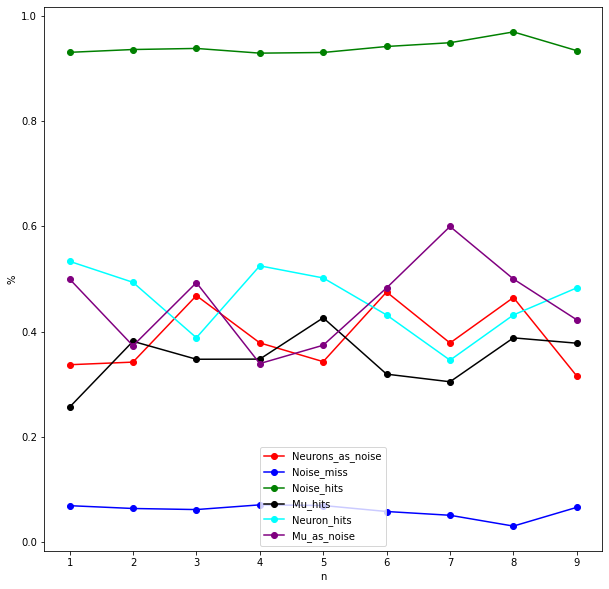

In [188]:
fig = plt.figure(figsize = (10,10))
plt.plot(np.arange(1,len(Neurons_as_noise_list)+1),np.array(Neurons_as_noise_list),'o-',c = 'red',label = 'Neurons_as_noise')

plt.plot(np.arange(1,len(Noise_misses_list)+1),np.array(Noise_misses_list),'o-',c = 'blue',
        label = 'Noise_miss')

plt.plot(np.arange(1,len(Noise_hits_list)+1),np.array(Noise_hits_list),'o-',c = 'green',
        label = 'Noise_hits')

plt.plot(np.arange(1,len(Mu_hits_list)+1),np.array(Mu_hits_list),'o-',c = 'black',
        label = 'Mu_hits')

plt.plot(np.arange(1,len(Neurons_hits_list)+1),np.array(Neurons_hits_list),'o-',c = 'cyan',
        label = 'Neuron_hits')

plt.plot(np.arange(1,len(Mu_as_noise_list)+1),np.array(Mu_as_noise_list),'o-',c = 'purple',
        label = 'Mu_as_noise')

counts = pd.DataFrame({'a':y_test})
counts = counts.a.value_counts().values

plt.legend()
plt.ylabel('%')
plt.xlabel('n')

## STATISTICS

In [190]:
d = {}
for i in np.arange(1,10):
    d[i] = []
    for j in range(15): d[i].append(confusion_matrix(*do_all_once(i),normalize = "true"))
    d[i] = np.array(d[i])

Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
Using Mahalanobis distance
U

In [191]:
d_mean = {i:d[i].mean(axis = 0) for i in d.keys()}
d_std = {i:d[i].std(axis = 0) for i in d.keys()}

In [192]:
noise_hits = [d_mean[i][1][1] for i in d.keys()]
noise_hits_std = [d_std[i][1][1] for i in d.keys()]

neuron_hits = [d_mean[i][0][0] for i in d.keys()]
neuron_hits_std = [d_std[i][0][0] for i in d.keys()]

mu_hits = [d_mean[i][2][2] for i in d.keys()]
mu_hits_std = [d_std[i][2][2] for i in d.keys()]

noise_miss = [d_mean[i][1][2] + d_mean[i][1][0] for i in d.keys()]
noise_miss_std = [np.sqrt(d_std[i][1][2]**2 + d_std[i][1][0]**2) for i in d.keys()]

neuron_misses_noise = [d_mean[i][0][1] for i in d.keys()]
neuron_misses_noise_std = [d_std[i][0][1] for i in d.keys()]

mu_misses_noise = [d_mean[i][2][1] for i in d.keys()]
mu_misses_noise_std = [d_std[i][2][1] for i in d.keys()]

<Figure size 720x720 with 0 Axes>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

<Figure size 720x720 with 0 Axes>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

<Figure size 720x720 with 0 Axes>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

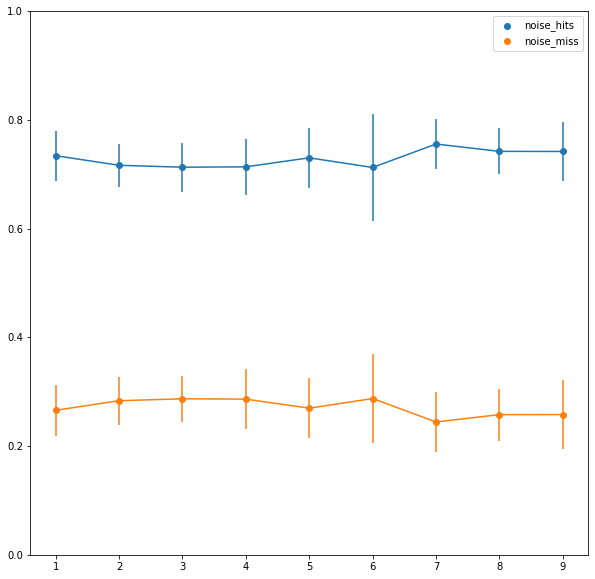

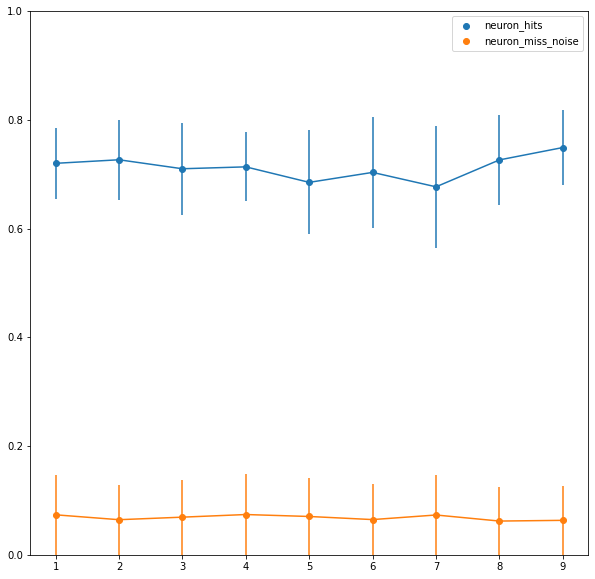

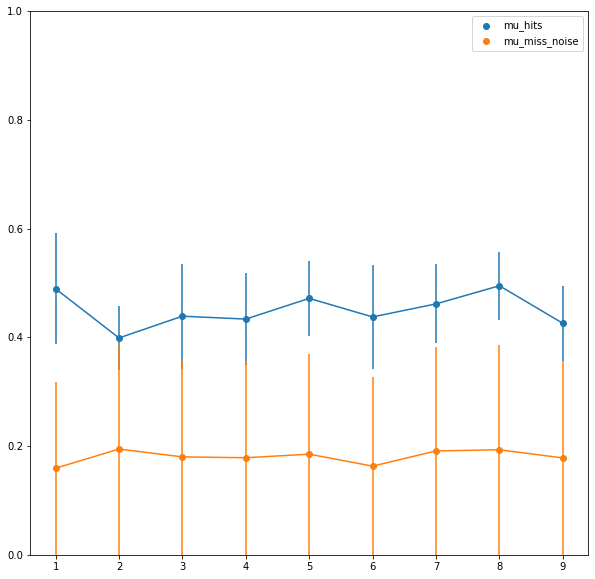

In [193]:
plt.figure(figsize=(10,10))
n = np.arange(1,10)
plt.scatter(n,noise_hits,marker = "o",label = "noise_hits")
plt.errorbar(n,noise_hits,yerr=noise_hits_std)
plt.scatter(n,noise_miss,marker = "o",label = "noise_miss")
plt.errorbar(n,noise_miss,yerr=noise_miss_std)
plt.ylim(0,1)
plt.legend()

plt.figure(figsize=(10,10))
plt.scatter(n,neuron_hits,marker = "o",label = "neuron_hits")
plt.errorbar(n,neuron_hits,yerr=neuron_hits_std)
plt.scatter(n,neuron_misses_noise,marker = "o",label = "neuron_miss_noise")
plt.errorbar(n,neuron_misses_noise,yerr=neuron_misses_noise)
plt.ylim(0,1)
plt.legend()

plt.figure(figsize=(10,10))
plt.scatter(n,mu_hits,marker = "o",label = "mu_hits")
plt.errorbar(n,mu_hits,yerr=mu_hits_std)
plt.scatter(n,mu_misses_noise,marker = "o",label = "mu_miss_noise")
plt.errorbar(n,mu_misses_noise,yerr=mu_misses_noise)
plt.ylim(0,1)
plt.legend()


In [ ]:
noise_hits